<a href="https://www.kaggle.com/code/rogerarendse/artstyleclassifier?scriptVersionId=131618587" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Art Style Classifier

The purpose of this notebook is to create an art style classifier using a pretrained neural network, which can identify and categorize art into one of three styles: Cubism, Surrealism, or Abstract Expressionism. To achieve this, we first collect and preprocess approximately 200 images per art style using DuckDuckGo image search. Next, we fine-tune the pretrained neural network to recognize these art styles. Finally, we test the model's performance on new images to evaluate its accuracy and generalization capabilities.

### Steps:
#### 1. Get and Preprocess data
   Use DuckDuckGo to search for images of art styles. Roughly 200 pictures per art style
   - Cubism:
    An art style that portrays objects from multiple viewpoints, deconstructing and reassembling them in geometric forms.
   - Surrealism:
    An artistic movement emphasizing the subconscious and dreamlike imagery, often featuring juxtaposed and illogical elements.
   - Abstract Expressionism:
   A spontaneous and emotive art style characterized by non-representational forms and energetic brushwork, conveying emotions and inner experiences.
   
#### 2. Train, Clean & Test the Model
   Fine-tune a pretrained neural network to recognise these styles. Test the model. Clean the data to improve performance. Test the model


In [1]:
# install updated version and import libraries
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# import libraries
from fastcore.all import *
from fastai.vision.all import *
from fastdownload import download_url
from IPython.display import display
from time import sleep

In [3]:
# view function documentation
??search_images_ddg

Signature: search_images_ddg(term, max_images=200)
Source:   
def search_images_ddg(term, max_images=200):
    "Search for `term` with DuckDuckGo and return a unique urls of about `max_images` images"
    assert max_images<1000
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    assert searchObj
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    headers = dict(referer='https://duckduckgo.com/')
    while len(urls)<max_images and 'next' in data:
        try:
            res = urlread(requestUrl, data=params, headers=headers)
            data = json.loads(res) if res else {}
            urls.update(L(data['results']).itemgot('image'))
            requestUrl = url + data['next']
        except (URLError,HTTPError): pass
        time.sleep(1)
    return L(urls)[:max_images]
File:      /opt/conda/lib/py

In [4]:
# create function to search for images
def search_images(image_name, max_images=100, test=False):
    if test==True:
        print(image_name)
        url = search_images_ddg(image_name, max_images=max_images)
    else:
        print(f'Searching for: {image_name}')
        url = search_images_ddg(image_name, max_images=max_images)
    return url

### Step 1: Get Data

cubism art


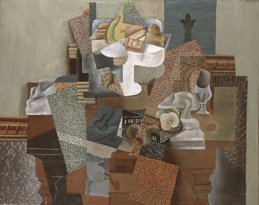

surrealism art


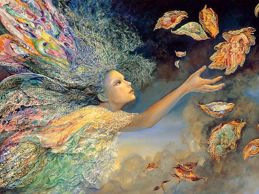

abstract expressionism art


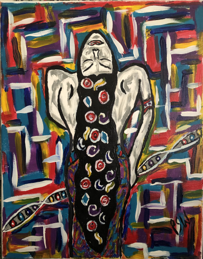

In [5]:
# view one image of various art styles  
style = 'cubism', 'surrealism', 'abstract expressionism'
for i in style:
    download_url(search_images(f'{i} art', max_images=1, test=True)[0], f'{i}.jpg', show_progress=False)
    img = Image.open(f'{i}.jpg').to_thumb(259, 259)
    display(img)

In [8]:
# build dataset 
style = 'cubism', 'surrealism', 'abstract expressionism'
path = Path('art')

for i in style:
    dest = (path/i)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=(search_images(f'{i} art', max_images=200)))

Searching for: cubism art
Searching for: surrealism art
Searching for: abstract expressionism art


In [9]:
# view number of images
print(f'Number of images: {len(get_image_files(path))}')

Number of images: 592


In [10]:
# verify images, remove and view failed images
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print(f'Failed images: {len(failed)}')

Failed images: 19


### Step 2: Train, Clean & Test the Model

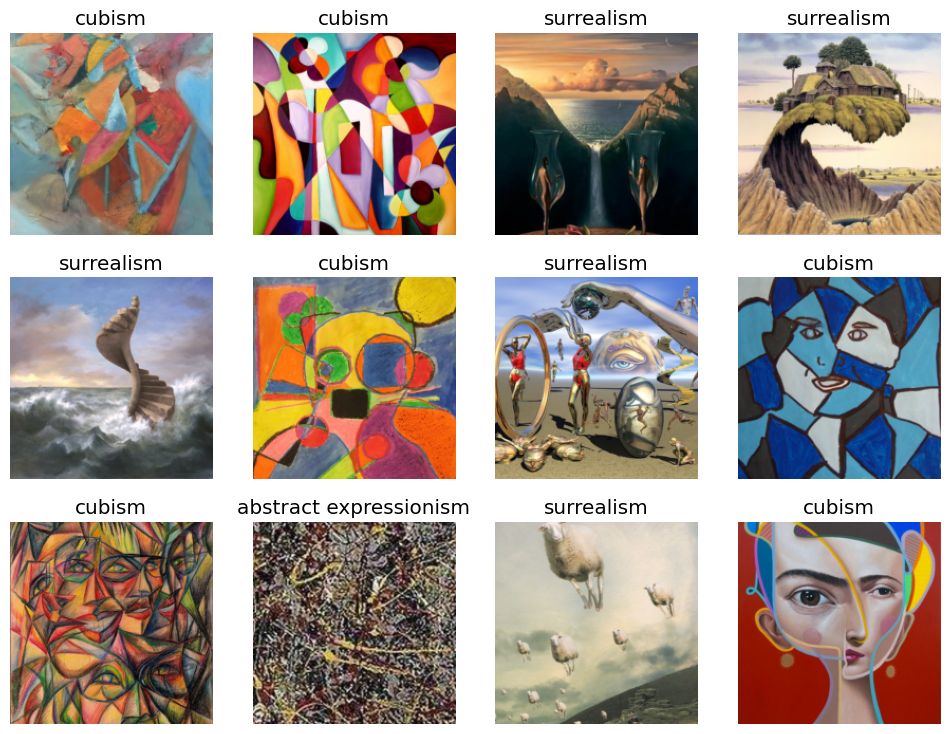

In [11]:
# create training and validation dataset
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192)]
).dataloaders(path, bs=32)

data.show_batch(max_n=12, nrows=3)


In [12]:
# train model before cleaning
learn = vision_learner(data, resnet18, metrics=error_rate)
learn.fine_tune(4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 151MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,1.245322,0.351883,0.105263,00:29


epoch,train_loss,valid_loss,error_rate,time
0,0.347386,0.211494,0.052632,00:26
1,0.224272,0.194755,0.052632,00:26
2,0.166323,0.218962,0.078947,00:27
3,0.129854,0.223917,0.061404,00:26


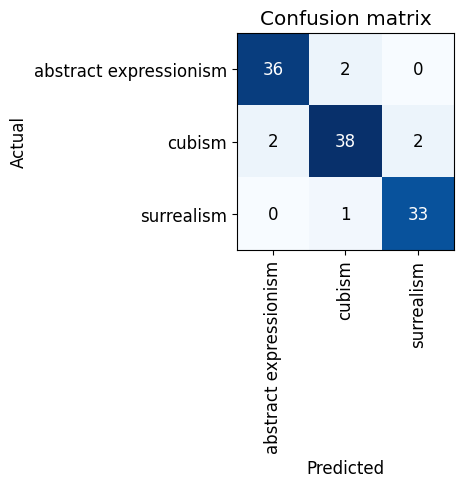

In [13]:
# use confusion matrix to view model performance 
# this will give an idea of what data needs cleaning
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

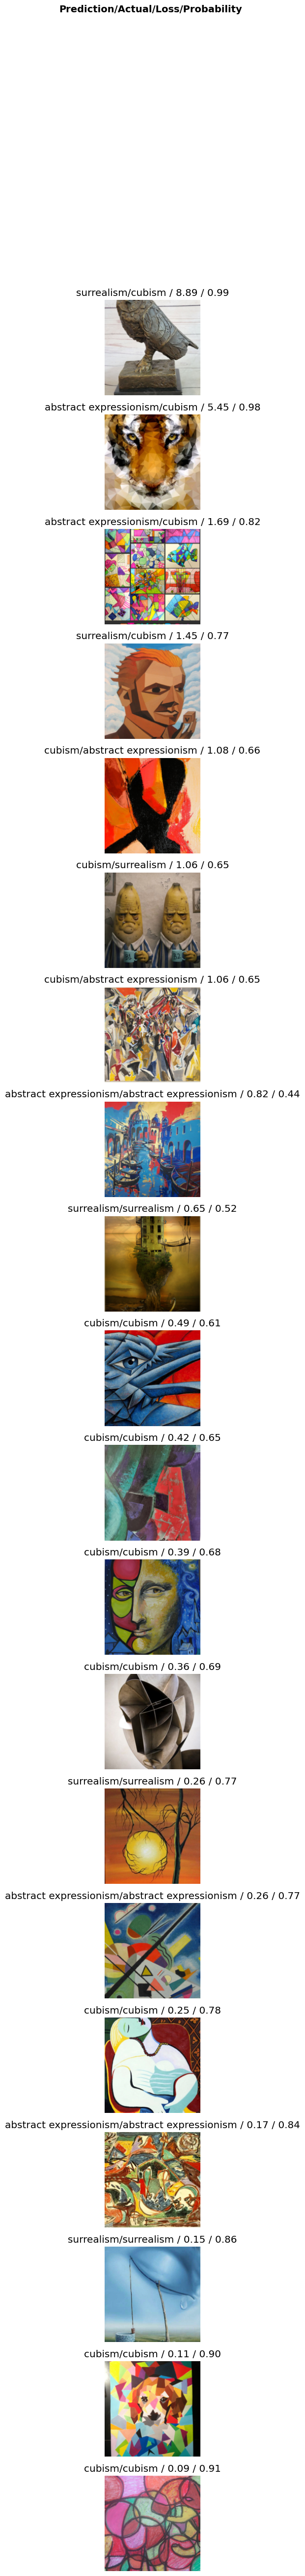

In [14]:
# plot top losses - prediction/actual/loss/probability
interp.plot_top_losses(20, nrows=20)

In [ ]:
# go through data for cleaning
#cleaner = ImageClassifierCleaner(learn)
#cleaner

In [ ]:
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

### Step 3: Create pickle file

In [15]:
# create a pickle file
from IPython.display import FileLink

learn.export('model.pkl')
FileLink('model.pkl')

/kaggle/working/model.pkl